<h1> QuantumSim - Surface Codes </h1>
Author: Michel Meulen<br>
Date: 05-12-2024<br>
<br>
This chapter introduces quantum error correction (QEC) and delves into the distance three surface code. The content presented here is based on a literature review available at INSERT LINK. To execute this notebook, two libraries are essential: quantumsim, likely familiar to you, and SOMETHING, providing circuits for the nine-qubit surface code.

A strong foundation in quantum computing, particularly the concepts explored in the chapter "QuantumSim - Shor's Nine Qubit Code," is recommended. This chapter clarifies the properties of specific quantum gates crucial for understanding the surface code, as well as the two primary error types: phase-flip (Z-errors) and bit-flip (X-errors).



In [2]:
from quantumsim import Circuit, QuantumUtil
# Qubit aliases
D1, D2, D3, D4, D5, D6, D7, D8, D9 = 0, 1, 2, 3, 4, 5, 6, 7, 8

Surface Codes - Basics
------------------------
Quantum error correction leverages multiple physical qubits to construct more resilient logical qubits. Within the surface code architecture, qubits are classified into two categories: data qubits, which store the actual quantum information, and ancillary qubits, which facilitate error detection and correction. By measuring ancillary qubits, we can identify potential errors in data qubits and apply appropriate recovery operations to maintain data integrity. This notebook delves into the fundamentals of the surface code, starting with the fundamental building blocks and concluding in a simulation of the rotated surface 17 code, providing a comprehensive understanding of the concept of surface codes.

Surface Codes - Architecture
----------------------------
Surface codes function through multiple stages. Initially, data qubits are encoded and entangled with each other. A portion of the algorithm is subsequently applied to all data qubits. It is probable that errors, such as bit-flip or phase-flip errors, will be introduced into the data qubits as a result of the application of these gates.

To detect and correct these errors, a syndrome extraction process is employed. During this stage, information about the errors, known as the syndrome, is extracted from the data qubits and stored in ancillary qubits. These ancillary qubits are then measured, and their measurement results are projected onto a classical system.

The classical system processes the measured syndrome values and feeds them into a decoder. The decoder analyzes the syndrome and determines the most likely error pattern that occurred. Based on this analysis, the decoder estimates the necessary recovery action, which involves applying corrective operations to the data qubits to reverse the effects of the errors.

To enhance the noise resilience of the qubits, this cycle of encoding, error detection, and correction can be repeated multiple times within a single quantum computation. However, this increased resilience comes at the cost of longer computation times which is crucial due qubits decoherence times and the speed of the decoder. Below is a visual representation of the different components and steps used to create a surface code system. The double lines indicate classical information flow, in contrast to quantum information flow which is indicated with single lines.

<img src="./pictures/qec_general/architecture_of_surface_code.drawio.png" alt="Architecture of the surface code" style="width:60%;"/>


Surface Codes - Encoding
--------------------------------
The encoder circuit for the rotated surface 17 code looks a bit more complicated than shown in the picture below. However for demonstration purposes an example Greenberger–Horne–Zeilinger (GHZ) state is used.

<img src="./pictures/surface_code/surface_code_GHZ_circuit.png" alt="Surface code encoding circuit" style="width:60%;"/>


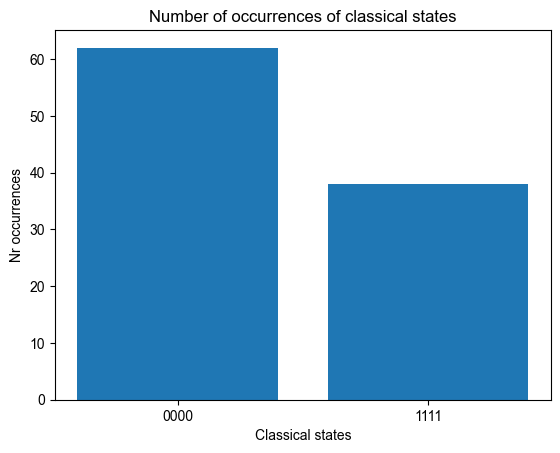

In [3]:
def create_GHZ_circuit(q: int, c: int) -> Circuit:
    circuit = Circuit(q, c, True)
    d1, d2, d3, d4 = 0, 1, 2, 3

    circuit.hadamard(d1)
    circuit.cnot(d1, d2)
    circuit.cnot(d2, d3)
    circuit.cnot(d3, d4)
    return circuit

def measure_data_qubits(circuit: Circuit):
    d1, d2, d3, d4 = 0, 1, 2, 3
    circuit.measurement(d1, d1)
    circuit.measurement(d2, d2)
    circuit.measurement(d3, d3)
    circuit.measurement(d4, d4)
    return circuit 

circuit = create_GHZ_circuit(4, 4)
circuit = measure_data_qubits(circuit)

result = QuantumUtil.measure_circuit_bit_register(circuit, 100)
QuantumUtil.histogram_of_classical_states(result)


Surface Codes - X Stabilizer
----------------------------
X-stabilizers are used in the surface code for detecting phase-flip errors. There are multiple ways of achieving syndrome measurement for detecting phase-flips. The main difference being the use of the CX (CNOT) or CZ gate as shown below.  

<img src="./pictures/surface_code/surface_code_x_stabilizer.png" alt="X stabilizer" style="width:60%;"/>

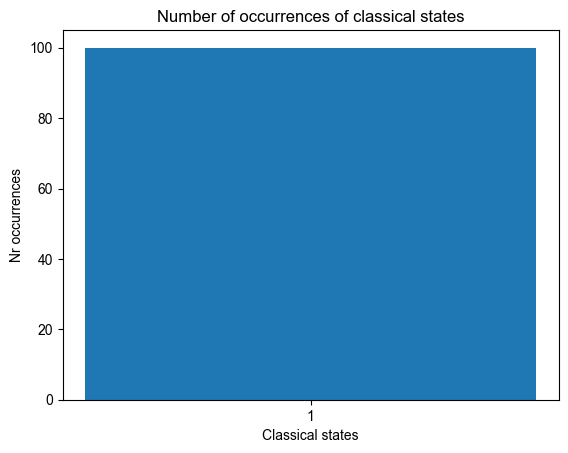

In [4]:
d1, d2, d3, d4, x1 = 0, 1, 2, 3, 4
circuit = create_GHZ_circuit(5, 1)

# Introduce Error
circuit.phaseflip_error(d1)

# Syndrome extraction
circuit.hadamard(x1)
circuit.cnot(x1, d3)
circuit.cnot(x1, d1)
circuit.cnot(x1, d4)
circuit.cnot(x1, d2)
circuit.hadamard(x1)

# Measurement of ancillary qubit x1, if measured as 1, there is a phase-flip, if measured as 0, there is no phase flip
circuit.measurement(x1, 0)

result = QuantumUtil.measure_circuit_bit_register(circuit, 100)
QuantumUtil.histogram_of_classical_states(result)

Surface Codes - Z Stabilizer
----------------------------
Z-stabilizers are used in the surface code for detecting bit-flip errors. There are multiple ways of achieving syndrome measurement for detecting bit-flips. The main difference being the use of the CX (CNOT) or CZ gate as shown below.  

<img src="./pictures/surface_code/surface_code_z_stabilizer.png" alt="Z stabilizer" style="width:60%;"/>

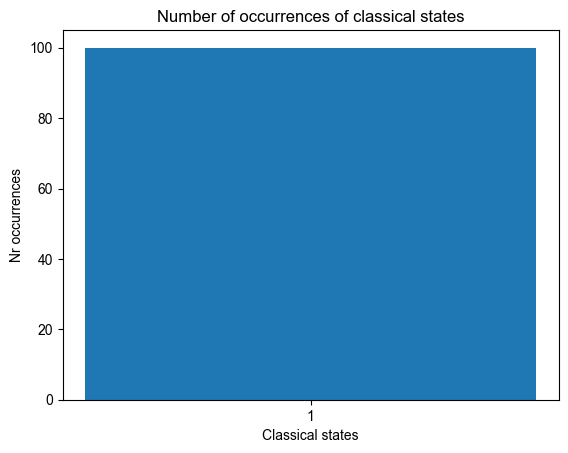

In [5]:
d1, d2, d3, d4, z1 = 0, 1, 2, 3, 4
circuit = create_GHZ_circuit(5, 1)

# Introduce Error
circuit.bitflip_error(d1)

# Syndrome extraction
circuit.cnot(d3, z1)
circuit.cnot(d4, z1)
circuit.cnot(d1, z1)
circuit.cnot(d2, z1)

# Measurement of ancillary qubit x1, if measured as 1, there is a bit-flip, if measured as 0, there is no bit flip
circuit.measurement(x1, 0)

result = QuantumUtil.measure_circuit_bit_register(circuit, 100)
QuantumUtil.histogram_of_classical_states(result)

Surface Codes - The Rotated Surface 17 Code - Encoder
-----------------------------------------------
Logical zero-state encoding of the nine-data-qubit surface code can be achieved using the following circuit on the left. Notice that each operation is marked with a number representing the order of operations. Starting with the initialization of four qubits in the Hadamard basis. The second step, creating bell states and GHZ states using multiple CNOT's. At last, applying two more CNOT's to form the logical zero state. For decoding all these mentioned operations are reverted resulting in the circuit showcased on the right:

<img src="./pictures/surface_code/rotated_surface_17_code_encoder.png" alt="Encoder circuit for rotated surface 17 code" style="width:30%;"/>
<img src="./pictures/surface_code/rotated_surface_17_code_decoder.png" alt="Decoder circuit for rotated surface 17 code" style="width:30%;"/>

Surface Codes - The Rotated Surface 17 Code - Syndrome Extraction
-----------------------------------------------
<img src="./pictures/surface_code/rotated_surface_17_code.png" alt="Rotated surface 17 code" style="width:30%;"/>


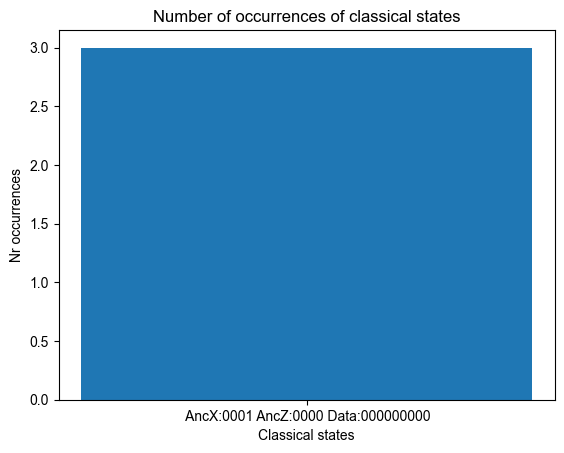

In [14]:
from SurfaceCodeQuantumSim import SurfaceCode

code = SurfaceCode()
code.add_encoder_circuit()
code.add_phase_flip(D9)
# code.add_bit_flip(D6)
# code.add_phase_flip(D1)

code.add_x_stabilizer_syndrome_extraction()
code.add_z_stabilizer_syndrome_extraction()

# code.add_decoder_circuit()
# code.add_measure_all_data_qubits() 

result = QuantumUtil.measure_circuit_bit_register(code.circuit, 3)
QuantumUtil.histogram_of_classical_states(result)